<a href="https://colab.research.google.com/github/mardom/astrostatistics-2020/blob/main/MNF_ICA_ML_tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

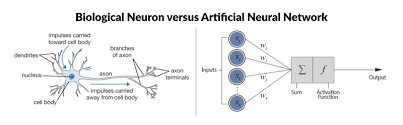

The biology inspired conexionist paradigm in Machine Learning dominates since 2012: https://playground.tensorflow.org/



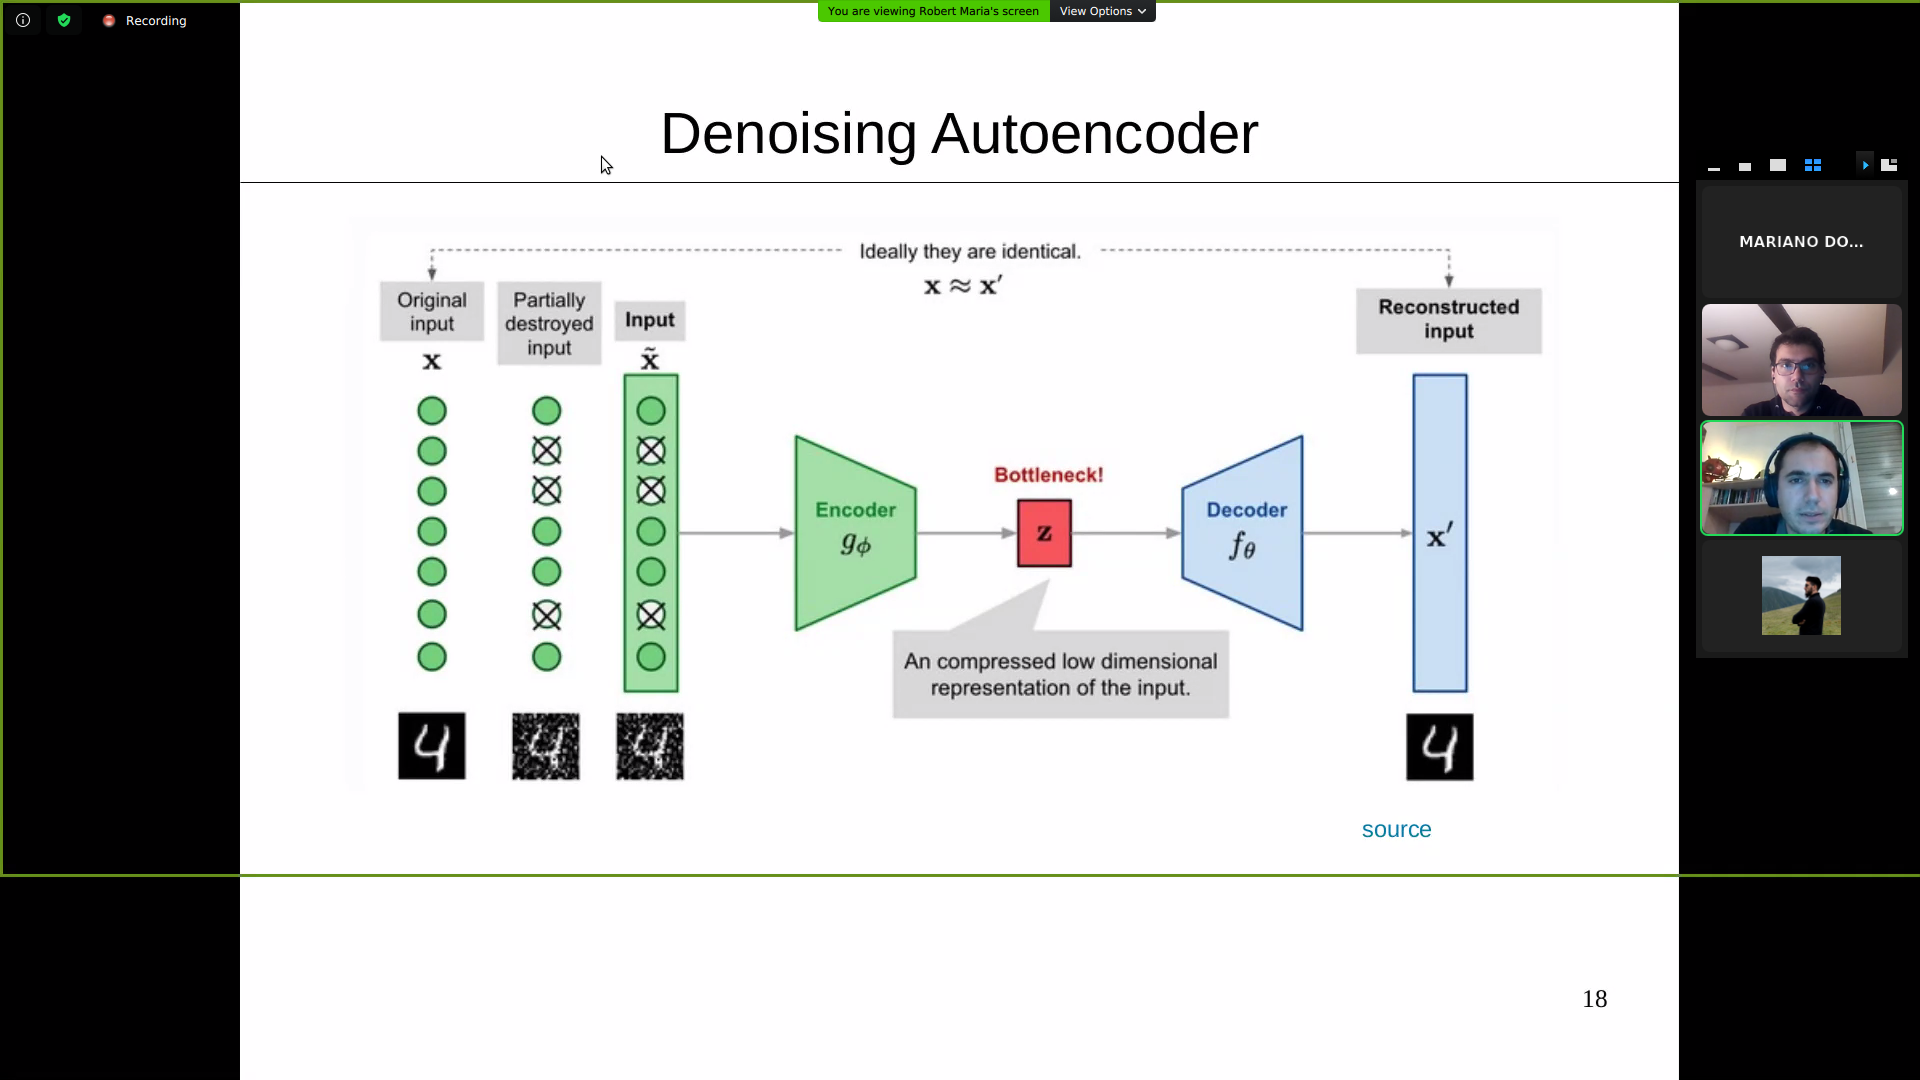

An important fact is that creates the "correct features" by itself https://blog.keras.io/building-autoencoders-in-keras.html

Please read this in the break: https://distill.pub/2018/building-blocks/



# Nonnegative Matrix Factorization
One of the challenges in interpreting PCA bases comes from the fact that the
eigenvectors are defined relative to the mean data vector. This results in principal
components that can be positive or negative. In contrast, for many physical systems
we have a priori knowledge that a data vector can be represented by a linear sum of
positive components. For example, in the case of the SDSS spectra, a galaxy spectrum
can be assumed to be a linear sum of stellar components (consistent with the general
form of the eigenspectra seen).

Nonnegative matrix factorization (NMF) applies an additional constraint on
the components that comprise the data matrix $X$. It assumes that any data
matrix can be factored into two matrices, $W$ and $Y$, such that

$$x=WY$$

where both $W$ and $Y$ are nonnegative (i.e., all elements in these matrices are nonneg-
ative). $WY$ is, therefore, an approximation of X. By minimizing the reconstruction
error $||(X − WY)^2 ||$, it can be shown that nonnegative bases can be derived using a
simple update rule,

$$W_{ki}=W_{ki}\frac{[XY^T]_{ki}}{[WYY^T]}_{ki}$$

$$Y_{in}=Y_{in}\frac{[W^T X]_{in}}{[W^T WY]}_{in}$$

where $n, k$, and $i$ denote the wavelength, spectrum and template indices, respectively.
 This iterative process does not guarantee nonlocal minima (as with many
iterative machine learning approaches such as K -means and EM). With random
initialization and cross-validation the solutions for the NMF bases are, however,
often appropriate.

The central panel in net figure shows the results of NMF applied to the spectra
used in the PCA analysis. The components derived by NMF are broadly
consistent with those from PCA but with a different ordering of the basis functions.
Given that both applications assume a linear transform between $X$ and $Y$ this might
not be that surprising. For the case of NMF, the assumption is that each spectrum can
be represented by a smaller number of nonnegative components than the underlying
dimensionality of the data. The number of components are, therefore, defined prior
to the generation of the NMF and can be derived through cross-validation techniques.

downloading PCA-processed SDSS spectra from https://github.com/astroML/astroML-data/raw/master/datasets/spec4000.npz to /root/astroML_data

@pickle_results: computing results and saving to 'spec_decompositions.pkl'


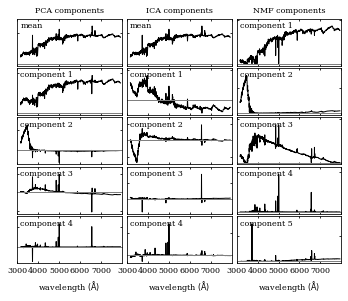

In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import NMF, FastICA, PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)


#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
#  we'll save the results so that they can be re-used
@pickle_results('spec_decompositions.pkl')
def compute_PCA_ICA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(spectra.T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(spectra.T).T])

    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components, random_state=0)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, ica_comp, nmf_comp

n_components = 5
decompositions = compute_PCA_ICA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 4))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


plt.show()

Scikit-learn contains an implementation of NMF. The basic usage is as follows:

In [ ]:
import numpy as np
from sklearn.decomposition import NMF
X = np.random.random((100, 3)) # 100 points in 3 dims, all positive
nmf = NMF(n_components=3) # setting n_components is optional
nmf.fit(X)
proj = nmf.transform(X) # project to 3 dimensions
comp = nmf.components_ # 3 x 10 array of components
err = nmf.reconstruction_err_ # how well 3 components captures data
err

0.0019193710388811759

# Manifold Learning

PCA, NMF, and other linear dimensionality techniques are powerful ways to reduce
the size of a data set for visualization, compression, or to aid in classification
and regression. Real-world data sets, however, can have very nonlinear features
which are hard to capture with a simple linear basis. For example, as we noted
before, while quiescent galaxies can be well described by relatively few principal
components, emission-line galaxies and quasars can require up to ∼ 30 linear
components to completely characterize. These emission lines are nonlinear features
of the spectra, and nonlinear methods are required to project that information onto
fewer dimensions.

Manifold learning comprises a set of recent techniques which aim to accomplish this sort of nonlinear dimensionality reduction. A classic test case for this is the S-curve data set, shown in next figure. This is a three-dimensional space, but the points are drawn from a two-dimensional manifold which is embedded in that space. Principal component analysis cannot capture this intrinsic information (see the upper-right panel of figure). There is no linear projection in which distant
parts of the nonlinear manifold do not overlap.

Manifold learning techniques, on the
other hand, do allow this surface to be unwrapped or unfolded so that the underlying
structure becomes clear. In light of this simple example, one may wonder what can be gained from such an algorithm. While projecting from three to two dimensions is a neat trick, these algorithms become very powerful when working with data like galaxy and quasar
spectra, which lie in up to 4000 dimensions. Vanderplas and Connolly https://iopscience.iop.org/article/10.1088/0004-6256/138/5/1365 first
applied manifold learning techniques to galaxy spectra, and found that as few as two
nonlinear components are sufficient to recover information which required dozens
of components in a linear projection.

There are a variety of manifold learning techniques and variants available. Here
we will discuss the two most popular: locally linear embedding (LLE) and IsoMap,
short for isometric mapping.

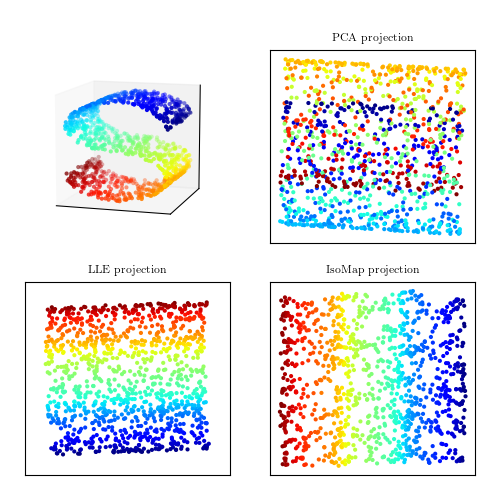

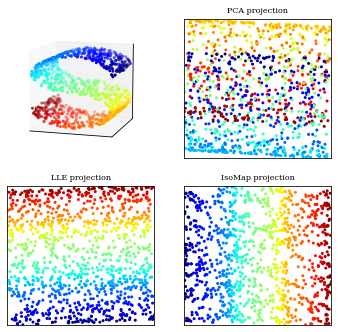

In [ ]:
"""
Comparison of PCA and Manifold Learning
---------------------------------------
Figure 7.8
A comparison of PCA and manifold learning. The top-left panel shows an example
S-shaped data set (a two-dimensional manifold in a three-dimensional space).
PCA identifies three principal components within the data. Projection onto the
first two PCA components results in a mixing of the colors along the manifold.
Manifold learning (LLE and IsoMap) preserves the local structure when
projecting the data, preventing the mixing of the colors.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

from sklearn import manifold, datasets, decomposition

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# generate the S-curve dataset
np.random.seed(0)

n_points = 1100
n_neighbors = 10
out_dim = 2

X, color = datasets.make_s_curve(n_points, random_state=0)
#samples_generator.make_s_curve(n_points)

# change the proportions to emphasize the weakness of PCA
X[:, 1] -= 1
X[:, 1] *= 1.5
X[:, 2] *= 0.5

#------------------------------------------------------------
# Compute the projections
pca = decomposition.PCA(out_dim)
Y_pca = pca.fit_transform(X)

lle = manifold.LocallyLinearEmbedding(n_neighbors, out_dim, method='modified',
                                      random_state=0, eigen_solver='dense')
Y_lle = lle.fit_transform(X)

iso = manifold.Isomap(n_neighbors, out_dim)
Y_iso = iso.fit_transform(X)

#------------------------------------------------------------
# plot the 3D dataset
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)
try:
    # matplotlib 1.0+ has a toolkit for generating 3D plots
    from mpl_toolkits.mplot3d import Axes3D
    ax1 = fig.add_subplot(221, projection='3d',
                          xticks=[], yticks=[], zticks=[])
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color,
                cmap=plt.cm.jet, s=9, lw=0)
    ax1.view_init(11, -73)

except:
    # In older versions, we'll have to wing it with a 2D plot
    ax1 = fig.add_subplot(221)

    # Create a projection to mimic 3D scatter-plot
    X_proj = X / (X.max(0) - X.min(0))
    X_proj -= X_proj.mean(0)
    R = np.array([[0.5, 0.0],
                  [0.1, 0.1],
                  [0.0, 0.5]])
    R /= np.sqrt(np.sum(R ** 2, 0))
    X_proj = np.dot(X_proj, R)

    # change line width with depth
    lw = X[:, 1].copy()
    lw -= lw.min()
    lw /= lw.max()
    lw = 1 - lw

    ax1.scatter(X_proj[:, 0], X_proj[:, 1], c=color,
                cmap=plt.cm.jet, s=9, lw=lw, zorder=10)

    # draw the shaded axes
    ax1.fill([-0.7, -0.3, -0.3, -0.7, -0.7],
             [-0.7, -0.3, 0.7, 0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.3, 0.7, 0.7, -0.3, -0.3],
             [-0.3, -0.3, 0.7, 0.7, -0.3], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.7, 0.3, 0.7, -0.3, -0.7],
             [-0.7, -0.7, -0.3, -0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)

    ax1.xaxis.set_major_locator(ticker.NullLocator())
    ax1.yaxis.set_major_locator(ticker.NullLocator())

#------------------------------------------------------------
# Plot the projections
subplots = [222, 223, 224]
titles = ['PCA projection', 'LLE projection', 'IsoMap projection']
Yvals = [Y_pca, Y_lle, Y_iso]

for (Y, title, subplot) in zip(Yvals, titles, subplots):
    ax = fig.add_subplot(subplot)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.jet, s=9, lw=0)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Locally Linear Embedding
Locally linear embedding http://www.robots.ox.ac.uk/~az/lectures/ml/lle.pdf is an unsupervised learning algorithm which attempts
to embed high-dimensional data in a lower-dimensional space while preserving
the geometry of local neighborhoods of each point. These local neighborhoods are determined by the relation of each point to its k nearest neighbors. The LLE algorithm consists of two steps: first, for each point, a set of weights is derived which best reconstruct the point from its k nearest neighbors. These weights encode the
local geometry of each neighborhood. Second, with these weights held fixed, a new
lower-dimensional data set is found which maintains the neighborhood relationships
described by these weights.

Let us be more specific. Let $X$ be an $N × K$ matrix representing $N$ points in $K$
dimensions. We seek an $N × N$ weight matrix $W$ which minimizes the reconstruction error

$$\epsilon_{1}(W)=|X-WX|^2$$

subject to certain constraints on $W$ which we will mention shortly.

Let us first examine this equation and think about what it means. With some added notation, we can write this in a way that is a bit more intuitive. Each point in the data set represented by $X$ is a $K$-dimensional row vector. We will denote the i-th row vector by $x_{i}$. Each point also has a corresponding weight vector given by the i-th row of the weight matrix $W$. The portion of the reconstruction error associated with this single point can be written:

$$\epsilon_{1}(W)=\sum_{i=1}^{N} | x_{i}-\sum_{j=1}^{N}W_{ij}x_{j}|$$

What does it mean to minimize this equation with respect to the weights W? What we are doing is finding the linear combination of points in the data set which best reconstructs each point from the others. This is, essentially, finding the hyperplane that best describes the local surface at each point within the data set. Each row of the weight matrix W gives a set of weights for the corresponding point. As written above,
the expression can be trivially minimized by setting $W = I$ , the identity matrix. In
this case, $WX = X$ and $\epsilon_{1}(W) = 0$. To prevent this simplistic solution, we can
constrain the problem such that the diagonal $W_{ii} = 0$ for all $i$ . This constraint leads
to a much more interesting solution. In this case the matrix $W$ would in some sense
encode the global geometric properties of the data set: how each point relates to all
the others.

The key insight of LLE is to take this one step further, and constrain all $W_{ij} = 0$
except when point $j$ is one of the $k$ nearest neighbors of point $i$. With this constraint
in place, the resulting matrix $W$ has some interesting properties. First, $W$ becomes
very sparse for $k << N$. Out of the $N^2$ entries in $W$, only $Nk$ are nonzero. Second,
the rows of $W$ encode the local properties of the data set: how each point relates to its
nearest neighbors. $W$ as a whole encodes the aggregate of these local properties, and
thus contains global information about the geometry of the data set, viewed through
the lens of connected local neighborhoods.

The second step of LLE mirrors the first step, but instead seeks an $N × d$
matrix $Y$, where $d < D$ is the dimension of the embedded manifold. $Y$ is found
by minimizing the quantity:

$$\epsilon_{2}=|Y-WY|^2$$

where this time W is kept fixed. The symmetry between eqs. is clear.
Because of this symmetry and the constraints put on W, local neighborhoods in the low-dimensional embedding, Y, will reflect the properties of corresponding local neighborhoods in X. This is the sense in which the embedding Y is a good nonlinear representation of X.

Algorithmically, the solutions to the two previuos eqs. can be obtained analytically
using efficient linear algebra techniques. The details are available in the literature, but we will summarize the results here. Step 1 requires a nearest-neighbor search https://grispy.readthedocs.io/en/latest/, followed by a least-squares solution to the corresponding row
of the weight matrix W. Step 2 requires an eigenvalue decomposition of the matrix 
$C_W ≡ (I − W)^T (I − W)$, which is an $N × N$ sparse matrix, where $N$ is the
number of points in the data set. Algorithms for direct eigenvalue decomposition scale as $O(N^3)$, so this calculation can become prohibitively expensive as N grows large. 

Iterative methods can improve on this: Arnoldi decomposition (related to the Lanczos method) allows a few extremal eigenvalues of a sparse matrix to be found relatively efficiently. A well-tested tool for Arnoldi decomposition is the
Fortran package ARPACK https://www.caam.rice.edu/software/ARPACK/. A full Python wrapper for ARPACK is available in the functions scipy.sparse.linalg.eigsh (for symmetric matrices) and
scipy.sparse.linalg.eigs (for asymmetric matrices). These tools are used in the manifold learning routines available in Scikit-
learn: see below.

In the astronomical literature there are cases where LLE has been applied to data as diverse as galaxy spectra, stellar spectra https://iopscience.iop.org/article/10.1088/0004-6256/142/6/203/meta, and photometric light curves https://arxiv.org/abs/1204.2113. In the case of spectra, the authors showed that the LLE projection results in a low-dimensional representation of the spectral information, while maintaining
physically important nonlinear properties of the sample. In the case of light curves, the LLE has been shown useful in aiding automated classification of observed objects via the projection of high-dimensional data onto a one-dimensional nonlinear sequence in the parameter space.



In [ ]:
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
X = np.random.normal(size = (1000, 2)) # 100 pts in 2 dims
R = np.random.random((2, 10)) # projection matrix
X = np.dot(X, R) # now a 2 D linear manifold in 10 D space
k = 5 # number of neighbors used in the fit
n = 2 # number of dimensions in the fit
lle = LocallyLinearEmbedding(k, n)
lle.fit(X)
proj = lle.transform(X) # 100 x 2 projection of data

# IsoMap
IsoMap https://web.mit.edu/cocosci/Papers/sci_reprint.pdf, short for isometric mapping, is another manifold learning method
which, interestingly, was introduced in the same issue of Science in 2000 as was LLE.
IsoMap is based on a multidimensional scaling (MDS) framework. Classical MDS is
a method to reconstruct a data set from a matrix of pairwise distances (for a detailed
discussion of MDS see https://www.springer.com/gp/book/9780387251509).

If one has a data set represented by an $N × K$ matrix $X$, then one can
trivially compute an $N × N$ distance matrix $D_ X$ such that $[D_X ]_{ij}$ contains the
distance between points i and j . Classical MDS seeks to reverse this operation:
given a distance matrix $D_X$ , MDS discovers a new data set $Y$ which minimizes the error:

$$\epsilon_{XY}=|\tau(D_x)-\tau(D_Y)|^2$$

where $\tau$ is an operator with a form chosen to simplify the analytic form of the
solution. In metric MDS the operator $\tau$ is given by

$$\tau(D)=\frac{HSH}{2}$$

where $S$ is the matrix of square distances $S_{ij} = D_{ij}^2$ , and $H$ is the “centering matrix” $H_{ij} = \delta_{ij} − 1/N$. This choice of $\tau$ is convenient because it can then be shown that the optimal embedding $Y$ is identical to the top $D$ eigenvectors of the matrix $\tau(D_X)$ (for a derivation of this property see https://onlinelibrary.wiley.com/doi/abs/10.1002/bimj.4710240520).

The key insight of IsoMap is that we can use this metric $MDS$ framework to
derive a nonlinear embedding by constructing a suitable stand-in for the distance
matrix $D_X$. IsoMap recovers nonlinear structure by approximating geodesic curves
which lie within the embedded manifold, and computing the distances between each
point in the data set along these geodesic curves. To accomplish this, the IsoMap
algorithm creates a connected graph $G$ representing the data, where $G_{ij}$ is the
distance between point $i$ and point $j$ if points $i$ and $j$ are neighbors, and $G_{ij} = 0$  otherwise. Next, the algorithm constructs a matrix $D_X^{'}$ such that $[D_X^{'}]_{ij}$ contains the length of the shortest path between point $i$ and $j$ traversing the graph $G$. Using
this distance matrix, the optimal d-dimensional embedding is found using the MDS algorithm discussed above.

IsoMap has a computational cost similar to that of LLE if clever algorithms are used. The first step (nearest-neighbor search) and final step (eigendecomposition of an N × N matrix) are similar to those of LLE.

In [ ]:
import numpy as np
from sklearn.manifold import Isomap
X = np.random.normal(size = ( 1000, 2 )) # 1000 pts in 2 dims
R = np.random.random(( 2, 10)) # projection matrix
X = np.dot(X , R) # X is now a 2 D manifold in  10 D space
k = 5 # number of neighbors used in the fit
n = 2 # number of dimensions in the fit
iso = Isomap(k , n)
iso.fit( X )
proj = iso.transform( X ) # 1000 x 2 projection of data

## Weaknesses of Manifold Learning
Manifold learning is a powerful tool to recover low-dimensional nonlinear projections of high-dimensional data. Nevertheless, there are a few weaknesses that prevent it from being used as widely as techniques like PCA:

- Noisy and gappy data: Manifold learning techniques are in general not well suited
to fitting data plagued by noise or gaps. To see why, imagine that a point in the data
set shown in figure 1 is located at $(x, y) = (0, 0)$, but not well constrained in the z
direction. In this case, there are three perfectly reasonable options for the missing z
coordinate: the point could lie on the bottom of the “S”, in the middle of the “S”, or on
the top of the “S”. For this reason, manifold learning methods will be fundamentally
limited in the case of missing data. One may imagine, however, an iterative approach
which would construct a (perhaps multimodal) Bayesian constraint on the missing
values. This would be an interesting direction for algorithmic research, but such a
solution has not yet been demonstrated.

- Tuning parameters: In general, the nonlinear projection obtained using these techniques depends highly on the set of nearest neighbors used for each point. One may select the k neighbors of each point, use all neighbors within a radius r of each point, or choose some more sophisticated technique. There is currently no solid recommendation in the literature for choosing the optimal set of neighbors for a
given embedding: the optimal choice will depend highly on the local density of each point, as well as the curvature of the manifold at each point. Once again, one may imagine an iterative approach to optimizing the selection of  eighbors based on these insights. This also could be an interesting direction for research.

- Dimensionality: One nice feature of PCA is that the dimensionality of the data set
can be estimated, to some extent, from the eigenvalues associated with the projected
dimensions. In manifold learning, there is no such clean mapping. In fact, we have no
guarantee that the embedded manifold is unidimensional! One can easily imagine a
situation where a data set is drawn from a two-dimensional manifold in one region,
and from a three-dimensional manifold in an adjacent region. Thus in a manifold
learning setting, the choice of output dimensionality is a free parameter. In practice,
either $d = 1, d = 2, or d = 3$ is often chosen, for the simple reason that it leads to
a projection which is easy to visualize! Another weakness of manifold learning is its sensitivity to outliers. In particular, even a single outlier between different regions of the manifold
can act to “short-circuit” the manifold so that the algorithm cannot find the correct
underlying embedding.

- Reconstruction from the manifold: Because manifold learning methods generally
do not provide a set of basis functions, any mapping from the embedded space to
the higher-dimensional input space must be accomplished through a reconstruction
based on the location of nearest neighbors. This means that a projection derived from
these methods cannot be used to compress data in a way that is analogous to PCA.
The full input data set and the full projected data must be accessed in order to map
new points between the two spaces.

With these weaknesses in mind, manifold learning techniques can still be used successfully to analyze and visualize large astronomical data sets. LLE has been applied successfully to several classes of data, both as a classification technique and an outlier detection technique. **These methods are ripe for explo-
ration of the high-dimensional data sets available from future large astronomical
surveys**

# Independent Component Analysis and Projection Pursuit
Independent component analysis (ICA) https://hal.archives-ouvertes.fr/hal-00417283/document is a computational technique that has
become popular in the biomedical signal processing community to solve what has
often been referred to as the “cocktail party problem”. In this problem, there are multiple microphones situated through out a room containing N people. Each microphone picks up a linear combination of the N voices. The goal of ICA is to use the concept of statistical independence to isolate (or unmix) the individual signals.

In the context of astronomical problems we will consider the application of ICA to the series of galaxy spectra used for PCA. In this example, each galaxy spectrum is considered as the microphone picking up a linear combination of input signals from individual stars and HII regions.

Each spectrum, $x_i(k)$, can now be described by:

$$x_1(k)=a_{11}s_1(k)+a_{12}s_2(k)+a_{13}s_3(k)+...$$

$$x_2(k)=a_{21}s_1(k)+a_{22}s_2(k)+a_{23}s_3(k)+...$$

$$x_3(k)=a_{31}s_1(k)+a_{32}s_2(k)+a_{33}s_3(k)+...$$

where $s_i (k)$ are the individual stellar spectra and $a_{ij}$ the appropriate mixing amplitudes. In matrix format we can write this as

$$X=AS$$

where $X$ and $S$ are matrices for the set of input spectra and stellar spectra, respec-
tively. Extracting these signal spectra is equivalent to estimating the appropriate
weight matrix, $W$, such that

$$S=WX$$

The principle that underlies ICA comes from the observation that the input signals, $s_i(k)$, should be statistically independent. Two random variables are considered statistically independent if their joint probability distribution, $f(x, y)$, can be fully described by a combination of their marginalized probabilities, that is,

$$f(x^p,y^q)=f(x^p)f(y^q)$$

where $p$ and $q$ represent arbitrary higher-order moments of the probability distributions. For the case of PCA, $p = q = 1$ and the statement of independence simplifies
to the weaker condition of uncorrelated data.

In most implementations of ICA algorithms the requirement for statistical independence is expressed in terms of the non-Gaussianity of the probability distributions. The rationale for this is that the sum of any two independent random variables will always be more Gaussian than either of the individual random variables
(i.e., from the central limit theorem). This would mean that, for the case of the
stellar components that make up a galaxy spectrum, if we identify an unmixing
matrix, $W$, that maximizes the non-Gaussianity of the distributions, then we would
be identifying the input signals. Definitions of non-Gaussianity range from the use of
the kurtosis of a distribution, the negentropy (the negative of the entropy of a distribution), and mutual information.

Related to ICA is projection pursuit http://www.yaroslavvb.com/papers/friedman-exploratory.pdf. Both techniques seek interesting directions within multivariate data sets. One difference is that in projection pursuit these directions are identified one at a time, while for ICA the search for these signals can be undertaken simultaneously. For each case, the definition of “interesting” is often expressed in terms of how non-Gaussian the distributions are after projections. Projection Pursuit can be considered as a subset of ICA.

Scikit-learn has an implementation of ICA based on the FastICA algorithm https://www.cs.helsinki.fi/u/ahyvarin/papers/TNN99new.pdf. It can be used as follows:

In [ ]:
import numpy as np
from sklearn.decomposition import FastICA
X = np.random.normal(size=(100, 2)) # 100 pts in 2 dims
R = np.random.random((2 ,5 )) # mixing matrix
X = np.dot (X , R) # X is now 2 D data in 5 D space
ica = FastICA(2) # fit two components
ica.fit(X)
proj = ica.transform(X) # 100 x 2 projection of data
comp = ica.components_ # components
sources = ica.sources # sources
# the 2 x 5 matrix of indep .
# the 1 0 0 x 2 matrix of

AttributeError: ignored

## The Application of ICA to Astronomical Data
In figure 1 we showed the set of spectra used to test PCA. From the eigenspectra and
their associated eigenvalues it was apparent that each spectrum comprises a linear
combination of basis functions whose shapes are broadly consistent with the spectral
properties of individual stellar types (O, A, and G stars).

 In the middle panel of figure 4 we apply ICA to these same spectra to define the independent components. As with PCA, preprocessing of the input data is an important component of any
ICA application. For each data set the mean vector is removed to center the data.
Whitening of the distributions (where the covariance matrix is diagonalized and
normalized to reduce it to the identity matrix) is implemented through an eigenvalue
decomposition of the covariance matrix.
The cost function employed is that of FastICA which uses an analytic approximation to the negentropy of the distributions. The advantage of FastICA is that each of the independent components can be evaluated one at a time. Thus
the analysis can be terminated once a sufficient number of components has been identified.

  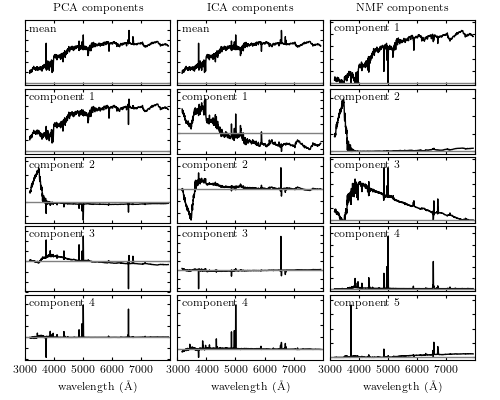

Comparison of the components derived from PCA, NMF and ICA in figure 4 shows that each of these decompositions produces a set of basis functions that are broadly similar (including both continuum and line emission). The ordering of the
importance of each component is dependent on technique: in the case of ICA, finding
a subset of ICA components is not the same as finding all ICA components, which means that the a priori assumption of the number of underlying components will affect the form of the resulting components. This choice of dimensionality is a
problem common to all dimensionality techniques (from LLE to the truncation of PCA components). As with many multivariate applications, as the size of the mixing
matrix grows, computational complexity often makes it impractical to calculate the
weight matrix W directly. Reduction in the complexity of the input signals through
the use of PCA (either to filter the data or to project the data onto these basis
functions) is often applied to ICA applications.

## Which Dimensionality Reduction Technique Should I Use? See table 7.1

# t-distributed Stochastic Neighbor Embedding.

t-SNE https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf

An illustration of t-SNE on the two concentric circles and the S-curve datasets for different perplexity values.

We observe a tendency towards clearer shapes as the perplexity value increases. For further details, “How to Use t-SNE Effectively”  https://distill.pub/2016/misread-tsne/ provides a good discussion of the effects of various parameters, as well as interactive plots to explore those effects.


Automatically created module for IPython interactive environment
circles, perplexity=5 in 1 sec
circles, perplexity=30 in 1.5 sec
circles, perplexity=50 in 1.4 sec
circles, perplexity=100 in 2.4 sec
S-curve, perplexity=5 in 1.1 sec
S-curve, perplexity=30 in 1.6 sec
S-curve, perplexity=50 in 1.3 sec
S-curve, perplexity=100 in 2 sec
uniform grid, perplexity=5 in 1.1 sec
uniform grid, perplexity=30 in 1.4 sec
uniform grid, perplexity=50 in 1.5 sec
uniform grid, perplexity=100 in 1.9 sec


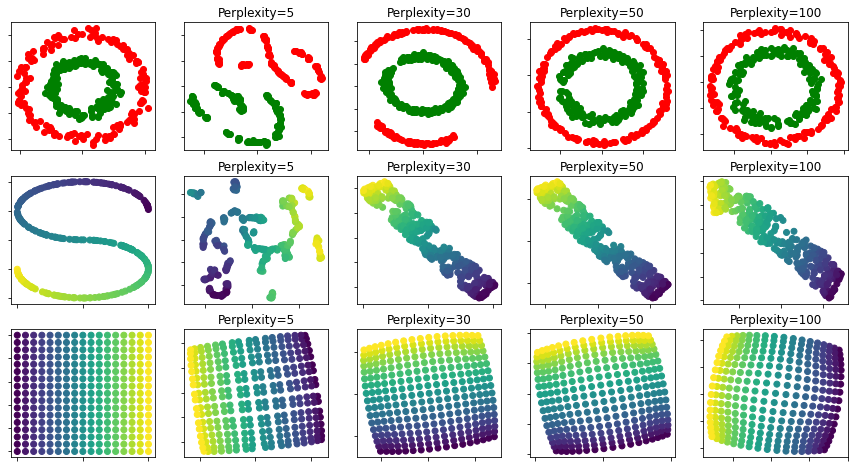

In [ ]:
# Author: Narine Kokhlikyan <narine@slice.com>
# License: BSD

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# Another example using s-curve
X, color = datasets.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack([
    xx.ravel().reshape(-1, 1),
    yy.ravel().reshape(-1, 1),
])
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.show()

Automatically created module for IPython interactive environment
LLE: 0.17 sec
LTSA: 0.25 sec
Hessian LLE: 0.35 sec
Modified LLE: 0.28 sec
Isomap: 0.54 sec
MDS: 1.7 sec
SE: 0.16 sec
t-SNE: 7.5 sec


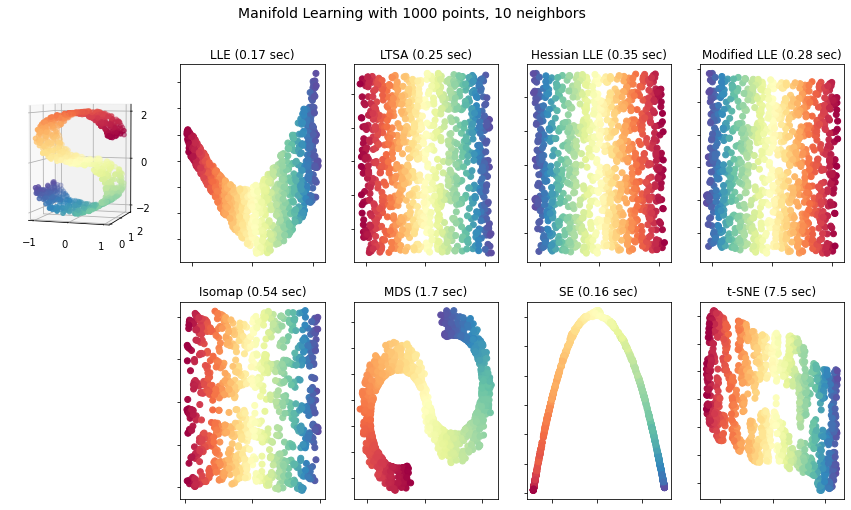

In [ ]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

In [ ]:
!pip install astroML

     |████████████████████████████████| 112kB 2.7MB/s 
  Created wheel for astroML: filename=astroML-0.4.1-cp36-none-any.whl size=128663 sha256=4b57590bc4f6b05976350a45570f3bdc67601ceab975390fdba99566990ed07c
  Stored in directory: /root/.cache/pip/wheels/7c/f2/f3/eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML


In [ ]:
import sklearn
sklearn.__path__

['/usr/local/lib/python3.6/dist-packages/sklearn']

In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scikit_learn-0.22.2.post1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/sklearn/*
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/uninstall.py", line 79, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_install.py", line 755, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_uninstall.py", line 388, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_uninstall.py", line 431, in _allowed_

In [ ]:
y

NameError: ignored